# Crypto Portfolio Selection 

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import polars as pl
import polars.selectors as cs

# Load data

In [2]:
import pandas as pd
import yfinance as yf

tickers = sorted([
        "BTC-USD",
        "ETH-USD",
        # "USDT-USD",
        # "USDC-USD",
        # "BNB-USD",
        # "SOL-USD",
        # "XRP-USD",
        # "STETH-USD",
    ])
data: pd.DataFrame = yf.download(
    tickers,
    start="2018-01-01",
    end="2024-01-01",
)["Close"].dropna()

[*********************100%***********************]  2 of 2 completed


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

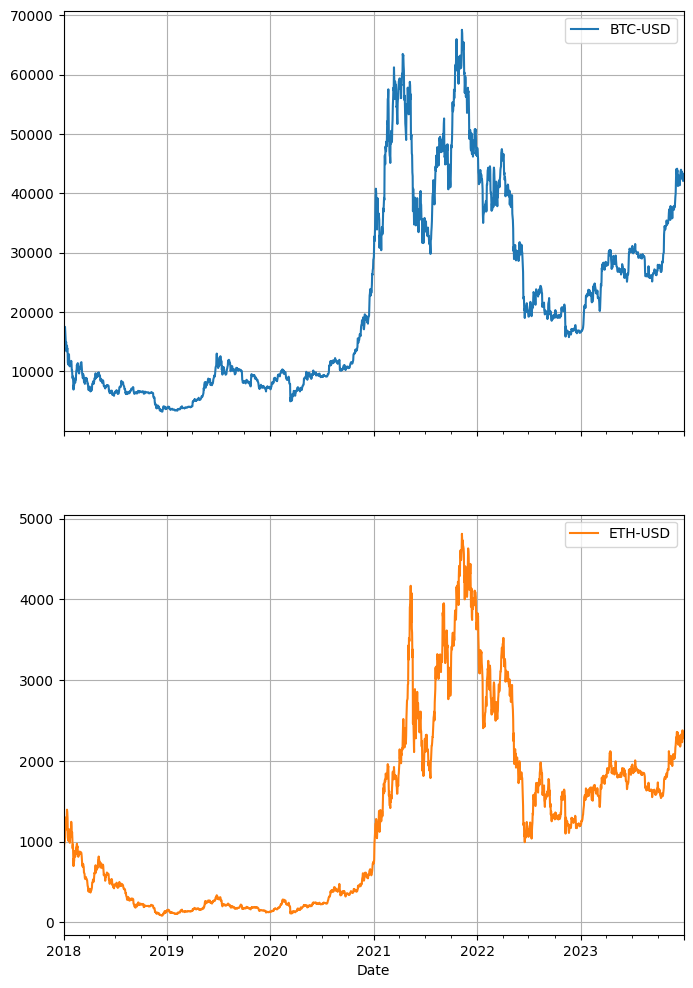

In [3]:
data.plot(grid=True, subplots=True, figsize=(8, 6*len(tickers)))

In [4]:
df_close = pl.from_dataframe(data.reset_index())
df_close

Date,BTC-USD,ETH-USD
"datetime[ns, UTC]",f64,f64
2018-01-01 00:00:00 UTC,13657.200195,772.640991
2018-01-02 00:00:00 UTC,14982.099609,884.44397
2018-01-03 00:00:00 UTC,15201.0,962.719971
2018-01-04 00:00:00 UTC,15599.200195,980.921997
2018-01-05 00:00:00 UTC,17429.5,997.719971
…,…,…
2023-12-27 00:00:00 UTC,43442.855469,2378.73999
2023-12-28 00:00:00 UTC,42627.855469,2347.566162
2023-12-29 00:00:00 UTC,42099.402344,2300.690674


In [5]:
df_returns = (
    df_close 
    .select(
        cs.datetime(),
        cs.float().pct_change(),
    )
    .drop_nulls()
)
df_returns

Date,BTC-USD,ETH-USD
"datetime[ns, UTC]",f64,f64
2018-01-02 00:00:00 UTC,0.097011,0.144702
2018-01-03 00:00:00 UTC,0.014611,0.088503
2018-01-04 00:00:00 UTC,0.026196,0.018907
2018-01-05 00:00:00 UTC,0.117333,0.017125
2018-01-06 00:00:00 UTC,0.005594,0.044061
…,…,…
2023-12-27 00:00:00 UTC,0.021694,0.065999
2023-12-28 00:00:00 UTC,-0.01876,-0.013105
2023-12-29 00:00:00 UTC,-0.012397,-0.019968


# Offline portfolio

In [6]:
from potato.benchmark import best_kelly_portfolio


returns = jnp.array(
    df_returns.to_numpy()[:, 1:]
)

long_only = best_kelly_portfolio(returns)
long_short = best_kelly_portfolio(returns, short_selling=True)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [7]:
df_static_portfolio_return = (
    df_returns
    .select(
        CRP = pl.sum_horizontal([pl.col(col) / len(tickers) for col in tickers]),
        kelly_long_only = pl.sum_horizontal([pl.col(col) * weight for col, weight in zip(df_returns.columns[1:], long_only)]),
        kelly_long_short = pl.sum_horizontal([pl.col(col) * weight for col, weight in zip(df_returns.columns[1:], long_short)]),
    )
)
df_static_portfolio_return

CRP,kelly_long_only,kelly_long_short
f64,f64,f64
0.120857,0.119333,0.105244
0.051557,0.049197,0.048649
0.022551,0.022784,0.018504
0.067229,0.07043,0.049662
0.024827,0.023598,0.023629
…,…,…
0.043847,0.042431,0.040075
-0.015933,-0.016113,-0.013038
-0.016182,-0.01594,-0.014175


optimal fixed porfolio

In [8]:
long_short

Array([0.35150072, 0.49165952], dtype=float32)

# Online portfolio

## Long/short portfolio

In [9]:
import optax
from potato.optimizer import egd
from potato.loss import kelly_loss

eta = 0.1
optimizer = egd(learning_rate=eta)
opt_state = optimizer.init(returns[0])

In [10]:
@jax.jit
def step(params, rs, state):
    loss, grad = jax.value_and_grad(kelly_loss)(params, rs)
    updates, state = optimizer.update(grad, state, params)
    params = optax.apply_updates(params, updates)
    return params, state, loss

params = jnp.ones(returns.shape[1]) / returns.shape[1]
weights = []
for i in range(returns.shape[0]):
    weights.append(params)
    params, opt_state, loss = step(params, returns[i], opt_state)
    # print(f"Step {i}: loss={loss}, params={params}")

weights = np.array(weights)

In [11]:
df_portfolio_return = df_static_portfolio_return.with_columns(
    PGD=pl.Series(values=np.sum(weights * np.array(returns), axis=-1))
)

In [12]:
df_portfolio_return

CRP,kelly_long_only,kelly_long_short,PGD
f64,f64,f64,f32
0.120857,0.119333,0.105244,0.120857
0.051557,0.049197,0.048649,0.051636
0.022551,0.022784,0.018504,0.022535
0.067229,0.07043,0.049662,0.067132
0.024827,0.023598,0.023629,0.024756
…,…,…,…
0.043847,0.042431,0.040075,0.04385
-0.015933,-0.016113,-0.013038,-0.015927
-0.016182,-0.01594,-0.014175,-0.016188


In [13]:
(
    df_returns
    .select(
        cs.numeric().mean() / cs.numeric().std() * jnp.sqrt(252)
    )
)

BTC-USD,ETH-USD
f64,f64
0.51829,0.545798


In [14]:
df_sharpes = (
    df_portfolio_return
    .select(cs.numeric().mean() / cs.numeric().std() * jnp.sqrt(252))
)
df_sharpes

CRP,kelly_long_only,kelly_long_short,PGD
f64,f64,f64,f32
0.559288,0.558703,0.559768,0.559729


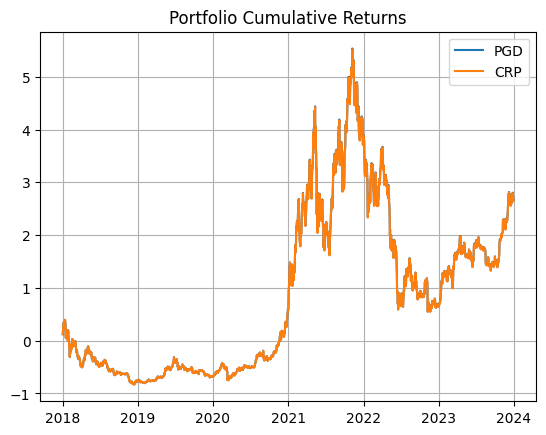

In [15]:
df_portfolio_cumret = (
    df_portfolio_return
    .select(cs.datetime(), cs.numeric().add(1).cum_prod().sub(1))
)

import matplotlib.pyplot as plt

plt.plot(df_returns["Date"], df_portfolio_cumret["PGD"], label="PGD")
plt.plot(df_returns["Date"], df_portfolio_cumret["CRP"], label="CRP")
# plt.plot(df_returns["Date"], df_portfolio_cumret["kelly_long_only"], label="kelly_long_only", linestyle="--", alpha=0.4)
# plt.plot(df_returns["Date"], df_portfolio_cumret["kelly_long_short"], label="kelly_long_short", linestyle="--", alpha=0.4)
plt.legend()
plt.grid()
plt.title("Portfolio Cumulative Returns")
plt.show()

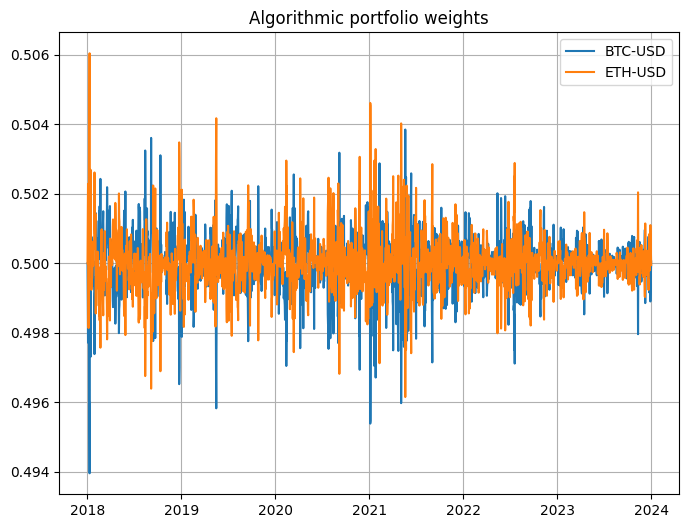

In [16]:
df_weights = pl.DataFrame(weights, schema={col: pl.Float64 for col in tickers})

fig, ax = plt.subplots(figsize=(8, 6))

for i, ticker in enumerate(tickers):
    ax.plot(df_returns["Date"], df_weights[ticker], label=ticker)

ax.legend()
ax.grid()
ax.set_title("Algorithmic portfolio weights")

plt.show()